**Topic :** CNN for classification <br>
**Author:** Arun Prakash A

* Connect to GPU run-time before start executing the code.

In [ ]:
import torch
# Check availability of gpus
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_properties(0))
print(torch.get_num_threads())

True
0
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)
1


In [ ]:
dtype = torch.float
device = torch.device('cuda:0')

* Let's load the modules we learned so far

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

* Load CIFAR-10 Dataset

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

* Let's check what are all the datasets available from torchvision module

In [ ]:
# Let us see the the available datasets
print(dir(torchvision.datasets))

['CIFAR10', 'CIFAR100', 'CLEVRClassification', 'CREStereo', 'Caltech101', 'Caltech256', 'CarlaStereo', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'Country211', 'DTD', 'DatasetFolder', 'EMNIST', 'ETH3DStereo', 'EuroSAT', 'FER2013', 'FGVCAircraft', 'FakeData', 'FallingThingsStereo', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'Flowers102', 'FlyingChairs', 'FlyingThings3D', 'Food101', 'GTSRB', 'HD1K', 'HMDB51', 'INaturalist', 'ImageFolder', 'ImageNet', 'InStereo2k', 'KMNIST', 'Kinetics', 'Kitti', 'Kitti2012Stereo', 'Kitti2015Stereo', 'KittiFlow', 'LFWPairs', 'LFWPeople', 'LSUN', 'LSUNClass', 'MNIST', 'Middlebury2014Stereo', 'MovingMNIST', 'Omniglot', 'OxfordIIITPet', 'PCAM', 'PhotoTour', 'Places365', 'QMNIST', 'RenderedSST2', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SUN397', 'SVHN', 'SceneFlowStereo', 'Sintel', 'SintelStereo', 'StanfordCars', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__', '__doc__', '_

In [ ]:
# # Load the dataset
transform = transforms.Compose(
                              [transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize((#mean),(#var))
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:06<00:00, 25197454.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(trainset.classes)
print(trainset.data.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)


* Use `DataLoader` class for batching the samples

In [ ]:
trainloader = DataLoader(trainset, batch_size=4,shuffle=True)
testloader = DataLoader(testset, batch_size=4,shuffle=False)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

* Let's display a few images

In [ ]:
x_train = iter(trainloader)

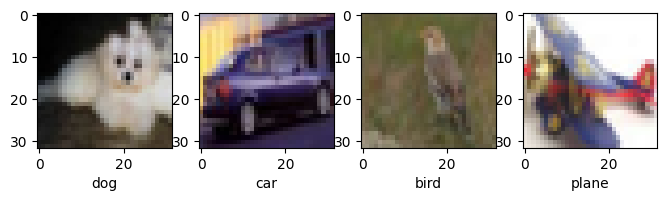

In [ ]:
imgs, labels = next(x_train)

fig,ax = plt.subplots(1,4,figsize=(8,10))
i = 0
for img,label in zip(imgs,labels):
  img = img/2 +0.5
  npimg = img.numpy()
  ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
  ax[i].set_xlabel(classes[label])
  i += 1

* Let's create a model

1.   **torch.nn.Conv2d**`(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros')`
2.   **torch.nn.MaxPool2d**`(kernel_size: Union[T, Tuple[T, ...]], stride: Optional[Union[T, Tuple[T, ...]]] = None, padding: Union[T, Tuple[T, ...]] = 0, dilation: Union[T, Tuple[T, ...]] = 1, return_indices: bool = False, ceil_mode: bool = False).`

3. **torch.nn.Linear**`(in_features: int, out_features: int, bias: bool = True)`


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

* Move the model to GPU

In [ ]:
model = Net()
model = model.to(device)
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = Loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # Loss
        running_loss += loss.item()
        # Accuracy
        class_correct = torch.argmax(outputs,axis=1) == torch.as_tensor(labels)
        running_acc += torch.count_nonzero(class_correct)/4
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f Accuracy:%.3f' %
                  (epoch + 1, i + 1, running_loss / 2000,running_acc/2000))
            running_loss = 0.0
            running_acc = 0.0


[1,  2000] loss: 2.193 Accuracy:0.173
[1,  4000] loss: 1.890 Accuracy:0.307
[1,  6000] loss: 1.675 Accuracy:0.386
[1,  8000] loss: 1.589 Accuracy:0.408
[1, 10000] loss: 1.535 Accuracy:0.440
[1, 12000] loss: 1.477 Accuracy:0.458
[2,  2000] loss: 1.396 Accuracy:0.502
[2,  4000] loss: 1.357 Accuracy:0.505
[2,  6000] loss: 1.351 Accuracy:0.515
[2,  8000] loss: 1.307 Accuracy:0.530
[2, 10000] loss: 1.309 Accuracy:0.533
[2, 12000] loss: 1.279 Accuracy:0.541


In [ ]:
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
test_acc = 0.0
total_sample = 0
for i, data in enumerate(testloader, 0):
   #get the inputs; data is a list of [inputs, labels]
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)

  class_correct = torch.argmax(outputs,axis=1) == torch.as_tensor(labels)

  total_sample += labels.shape[0]
  test_acc += torch.count_nonzero(class_correct)

print(test_acc/total_sample)

tensor(0.5405, device='cuda:0')


# Using pre-trained model for classification

## AlexNet

In [ ]:
from torchvision import models
#Load the image
from PIL import Image
import requests
from io import BytesIO

In [ ]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
alexNet = models.alexnet(pretrained=True)
transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 83.8MB/s]


In [ ]:
print(alexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

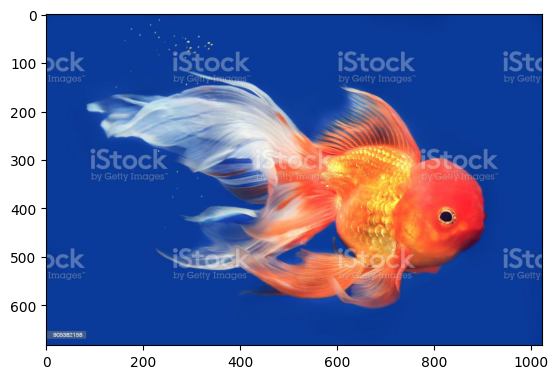

In [ ]:
#response = requests.get("https://i.insider.com/5ef54cb61918242cfb4ec653?width=1100&format=jpeg&auto=webp")
#response = requests.get("https://www.dogtime.com/assets/uploads/2011/01/file_23188_german-shepherd-dog.jpg")
#response = requests.get("https://www.mysis.com/hobbyist/wp-content/uploads/sites/2/2018/09/Goldfish-Image-1024x694.jpg")
response = requests.get("https://media.istockphoto.com/photos/beautiful-lionhead-goldfish-swimming-in-the-aquarium-picture-id905382158")
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [ ]:
img_t = transform(img)
batch = torch.unsqueeze(img_t,0)
alexNet.eval()
pred = alexNet(batch)
print(pred.shape)

torch.Size([1, 1000])


In [ ]:
#Load imagnet class names
!git clone https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
with open("942d3a0ac09ec9e5eb3a/imagenet1000_clsidx_to_labels.txt") as f:
  classes = [line.strip() for line in f.readlines()]

Cloning into '942d3a0ac09ec9e5eb3a'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), 13.22 KiB | 1.20 MiB/s, done.


In [ ]:
labels = []
for label in classes:
  labels.append(label.rsplit(':')[1])

In [ ]:
print(labels)

[" 'tench, Tinca tinca',", " 'goldfish, Carassius auratus',", " 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',", " 'tiger shark, Galeocerdo cuvieri',", " 'hammerhead, hammerhead shark',", " 'electric ray, crampfish, numbfish, torpedo',", " 'stingray',", " 'cock',", " 'hen',", " 'ostrich, Struthio camelus',", " 'brambling, Fringilla montifringilla',", " 'goldfinch, Carduelis carduelis',", " 'house finch, linnet, Carpodacus mexicanus',", " 'junco, snowbird',", " 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',", " 'robin, American robin, Turdus migratorius',", " 'bulbul',", " 'jay',", " 'magpie',", " 'chickadee',", " 'water ouzel, dipper',", " 'kite',", " 'bald eagle, American eagle, Haliaeetus leucocephalus',", " 'vulture',", " 'great grey owl, great gray owl, Strix nebulosa',", " 'European fire salamander, Salamandra salamandra',", " 'common newt, Triturus vulgaris',", " 'eft',", " 'spotted salamander, Ambystoma maculatum',", " 'axo

In [ ]:
_, index = torch.max(pred,1)
percentage = torch.nn.functional.softmax(pred, dim=1)[0] * 100
print('The Image is :{0} with a confidence:{1}'.format(labels[index[0]],percentage[index[0]].item()))

The Image is : 'jellyfish', with a confidence:80.9850082397461


## ResNet

In [ ]:
resNet = models.resnet101(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 242MB/s]


In [ ]:
img_t = transform(img)
batch = torch.unsqueeze(img_t,0)
resNet.eval()
pred = resNet(batch)
_, index = torch.max(pred,1)
percentage = torch.nn.functional.softmax(pred, dim=1)[0] * 100
print('The Image is :{0} with a confidence:{1}'.format(labels[index[0]],percentage[index[0]].item()))

The Image is : 'goldfish, Carassius auratus', with a confidence:99.95813751220703
